In [26]:
import ember
import numpy as np
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from keras.models import Model
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, cohen_kappa_score, roc_curve, \
    roc_auc_score, f1_score, precision_score, recall_score
from sklearn.utils import resample
from matplotlib import pyplot
import scipy.stats as stats

In [2]:
#UPDATE THIS PATH
X_train, y_train, X_test, y_test = ember.read_vectorized_features("/Users/alexandrutodea/Downloads/ember2018_data")

**Finds the positions of all benign samples in the training set**


In [3]:
ben = np.where(y_train == 0)

**Finds the positions of all malicious samples in the training set**

In [4]:
mal = np.where(y_train == 1)

**Combines all training indices (both benign and malicious)**

In [5]:
n = np.concatenate((ben, mal), axis=1).reshape(600000)

**Random seed set by the authors of https://ieeexplore.ieee.org/abstract/document/10460035**

In [6]:
np.random.seed(314)

**Randomly shuffles the indices in n**

In [7]:
np.random.shuffle(n)

**Picks benign and malicious samples from y_train in the shuffled order**

In [8]:
y_train = y_train[n]

**Picks benign and malicious samples from X_train in the shuffled order**

In [9]:
X_train = X_train[n]

**Checks the Sizes to Ensure Everything is OK**

In [10]:
X_train_rows, X_train_columns = X_train.shape
X_test_rows, X_test_columns = X_test.shape
y_train_shape = y_train.shape
y_test_shape = y_test.shape
print("Number of rows in X_train: ", X_train_rows)
print("Number of columns in X_train: ", X_train_columns)
print("Number of rows in X_test: ", X_test_rows)
print("Number of columns in X_test: ", X_test_columns)
print("y_train Shape (should be 1D): ", y_train_shape)
print("y_test Shape (should be 1D): ", y_test_shape)

Number of rows in X_train:  600000
Number of columns in X_train:  2381
Number of rows in X_test:  200000
Number of columns in X_test:  2381
y_train Shape (should be 1D):  (600000,)
y_test Shape (should be 1D):  (200000,)


**Defines NN model**

In [14]:
modinput = Input(shape=(X_train.shape[1],), dtype='float32', name='Input')
BNOne = BatchNormalization(name='BatchNormalization_Input')(modinput)
denseLayerOne = Dense(512, activation='tanh', name='Dense1')(BNOne)
denseLayerTwo = Dense(128, activation='tanh', name='Dense2')(denseLayerOne)
BNTwo = BatchNormalization(name='BatchNormalization_Dense2')(denseLayerTwo)
denseLayerThree = Dense(8, activation='tanh', name='Dense3')(BNTwo)
output = Dense(2, activation='softmax', name='Out')(denseLayerThree)

DLModel = Model(modinput, output, name='DLModel')
DLModel.summary()

Model: "DLModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2381)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization_Input        │ (None, 2381)           │         9,524 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 512)            │     1,219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization_Dense2       │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Out (Dense)                     │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,334 (4.95 MB)

 Trainable params: 1,291,316 (4.93 MB)

 Non-trainable params: 5,018 (19.60 KB)

**Loads NN Weights from the Path to Where They Were Saved in the First Notebook**

In [15]:
#UPDATE THIS PATH
DLModel.load_weights("/Users/alexandrutodea/Developer/Connors Model Weights/DLModel9505accuracy.weights.h5")

**Dropping features with variance < 0.001**. "No change in the features implies no conditional change on the target from which to learn." (Machine Learning for Tabular Data by Mark Ryan and Luca Massaron)


In [17]:
vt = VarianceThreshold(threshold=1e-3)
X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)

**Verifying that the Columns Were Dropped**

In [18]:
print(X_train_vt.shape[1])
print(X_test_vt.shape[1])

1658
1658


**Trains RF Model on Variance-Filtered Dataset**

In [32]:
rfm_reduced = RandomForestClassifier(n_estimators=100)  #max_depth=None, min_samples_split=2
rfm_reduced.fit(X_train_vt, y_train)

RandomForestClassifier()

**Make Predictions on Variance-Filtered Testing Set**

In [33]:
rfm_reduced_ypred = rfm_reduced.predict(X_test_vt)

**Part VII: Computing Confidence Intervals for the best Model: The RF Trained on the Variance-Filtered Dataset**


In [28]:
n = 5000 #the number of bootstrap testing sets to generate
accuracy_scores = [] #model classification accuracies on each of the bootstrap testing sets
test_sample_positions = np.arange(len(y_test))

for i in range(n):
    idx = resample(test_sample_positions, replace=True) #draw n testing set positions with replacement
    accuracy_scores.append(accuracy_score(y_test[idx], rfm_reduced_ypred[idx])) #compute the accuracy comparing the true labels with the predicted labels for the testing samples at the drawn positions

ci_low, ci_high = np.percentile(accuracy_scores, [2.5, 97.5]) #compute the 95% confidence interval
mean_accuracy = np.mean(accuracy_scores)
print(f"accuracy = {mean_accuracy :.3f}  (95 % CI: {ci_low:.3f} – {ci_high:.3f})")

accuracy = 0.967  (95 % CI: 0.966 – 0.968)


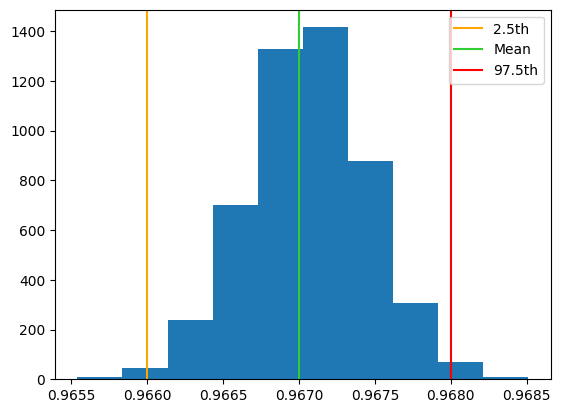

In [29]:
pyplot.hist(accuracy_scores)

# add vertical lines at 0.966 and 0.968
pyplot.axvline(x=0.966, color='orange', label='2.5th')
pyplot.axvline(x=0.967, color='limegreen', label='Mean')
pyplot.axvline(x=0.968, color='red', label='97.5th')

# optional: add a legend
pyplot.legend()

pyplot.show()

**Part VIII: Wilcoxon Test**

In [30]:
#These accuracies were obtained by running the cells in parts I and III 10 times
accuraciesDLModel = [0.9505, 0.9511, 0.9519, 0.9511, 0.9502, 0.9512, 0.9511, 0.9510, 0.9493, 0.9469]
accuraciesRFVarReduced = [0.9671, 0.9676, 0.9686, 0.9690, 0.9685, 0.9685, 0.9681, 0.9683, 0.9686, 0.9688]

accuraciesDLModelSorted = sorted(accuraciesDLModel)
accuraciesRFVarReducedSorted = sorted(accuraciesRFVarReduced)

print("accuraciesDLModel length: ", len(accuraciesDLModel), " accuracy range: ", accuraciesDLModelSorted[0], "-", accuraciesDLModelSorted[9])
print("accuraciesRFVarReduced length: ", len(accuraciesRFVarReduced), " accuracy range: ", accuraciesRFVarReducedSorted[0], "-", accuraciesRFVarReducedSorted[9])

#Null hypothesis: the tested algorithms have similar performance
#p-values <= 0.05 --> null hypothesis is rejected

stat, p_value = stats.wilcoxon(accuraciesDLModel, accuraciesRFVarReduced)

print("p-value: ", p_value)

if p_value <= 0.05:
    print("There were significant differences between the models.")
else:
    print("There were no significant differences between the models.")

accuraciesDLModel length:  10  accuracy range:  0.9469 - 0.9519
accuraciesRFVarReduced length:  10  accuracy range:  0.9671 - 0.969
p-value:  0.001953125
There were significant differences between the models.


**Part IX: Comparing ROC AUC**

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 717us/step
Variance-Filtered RF AUC: 0.9946
Connors and Sarkar NN AUC: 0.9851


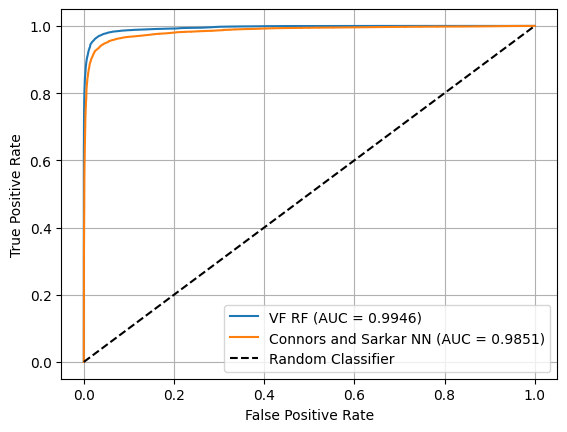

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_scores_rfm_reduced = rfm_reduced.predict_proba(X_test_vt)[:, 1]
probs_DL = DLModel.predict(X_test)          # shape (n_samples, n_classes)
y_scores_DL = probs_DL[:, 1]

# Compute AUC
auc1 = roc_auc_score(y_test, y_scores_rfm_reduced)
auc2 = roc_auc_score(y_test, y_scores_DL)

print(f"Variance-Filtered RF AUC: {auc1:.4f}")
print(f"Connors and Sarkar NN AUC: {auc2:.4f}")

# Plot ROC curves
fpr1, tpr1, _ = roc_curve(y_test, y_scores_rfm_reduced)
fpr2, tpr2, _ = roc_curve(y_test, y_scores_DL)

plt.plot(fpr1, tpr1, label=f'VF RF (AUC = {auc1:.4f})')
plt.plot(fpr2, tpr2, label=f'Connors and Sarkar NN (AUC = {auc2:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()